In [1]:
import ephem
import json
from shapely.geometry import shape, mapping, Point
import fiona
import gdal
import ogr, osr
import struct
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

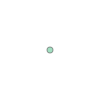

In [2]:
# Load site using shapely

with open ('inputs/site.geojson') as f:
    js = json.load(f)

s = shape(js['features'][0]['geometry'])
s

In [3]:
# Load digital elevation model

dem = gdal.Open('inputs/dem/filled.tif')

In [4]:
# Reproject the site to coords of dem for sampling elevation

site = ogr.Geometry(ogr.wkbPoint) # create an ogr geom instead of shapely
site.AddPoint(s.x, s.y)

sr = dem.GetProjection()
destSR = osr.SpatialReference()
inSRS_converter = osr.SpatialReference()
inSRS_converter.ImportFromWkt(sr)
inSRS_proj4 = inSRS_converter.ExportToProj4()
destSR.ImportFromProj4(inSRS_proj4)

srcSR = osr.SpatialReference()
srcSR.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
srTrans = osr.CoordinateTransformation(srcSR,destSR)

site_reproj = site
site.Transform(srTrans)
print(site_reproj.ExportToWkt())

POINT (-3010468.19566961 753062.757047171 0)


In [5]:
# Get site elevation

gt=dem.GetGeoTransform()
rb=dem.GetRasterBand(1)


def get_elev_at_point(geotransform, rasterband, pointgeom):
    mx,my=pointgeom.GetX(), pointgeom.GetY()
    #Convert from map to pixel coordinates.
    #Only works for geotransforms with no rotation.
    px = int((mx - geotransform[0]) / geotransform[1]) #x pixel
    py = int((my - geotransform[3]) / geotransform[5]) #y pixel
    intval=rasterband.ReadAsArray(px,py,1,1)[0]
    return intval[0]
    
site_elev = get_elev_at_point(gt, rb, site_reproj)
site_elev

1304.3667

Doing the viewshed analysis in QGIS using https://github.com/zoran-cuckovic/QGIS-visibility-analysis

Options:
- horizon search radius 20 km
- target (site) height 2 meters above surface
- adapting out 3 pixels (15 meters/~50 feet) from site to find high spot


Kept working in qgis for speed, will convert to this notebook eventually

In QGIS the horizon was:
- converted to ascii
- imported as points

Then:
- the dem was sampled with the horizon pts
- distance to site from each point calculated (m)
- inclination angle to each point calculated degrees(atan((horizon_elev-site_elev)/distance)

Bearing calculated using
```
degrees(atan(($x_at(0)-site_lon)/($y_at(0)-site_lat))) + (180 *((($y_at(0)-site_lat) < 0) + ((($x_at(0)-site_lon) < 0 AND ($y_at(0)-site_lat) >0)*2)))
```

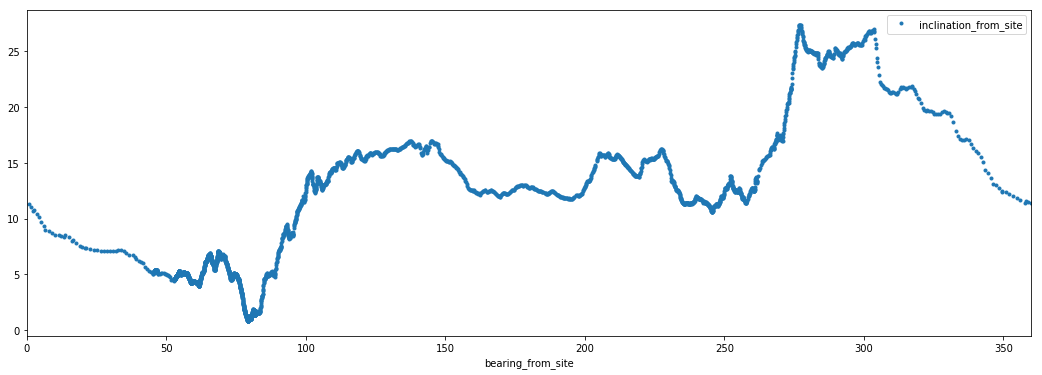

In [6]:
df = pd.read_csv('inputs/viewshed/horizon_dist.csv')
df.plot(x='bearing_from_site', y='inclination_from_site', style='.', figsize=(18,6), xlim=(0, 360))

In [7]:
df.loc[df['inclination_from_site'].idxmax()]

long                    -1.490663e+02
lat                      6.190995e+01
epsg3413_x              -3.009868e+06
epsg3413_y               7.541475e+05
elevation                1.947183e+03
id                       7.380000e+02
meters_from_site         1.239961e+03
inclination_from_site    2.740297e+01
bearing_from_site        2.771625e+02
Name: 737, dtype: float64

In [8]:
observer = ephem.Observer()
observer.lon = s.x
observer.lat = s.y
observer.elevation = site_elev
observer

<ephem.Observer date='2017/5/17 01:20:08' epoch='2000/1/1 12:00:00' lon='-8539:36:18.6' lat='3547:01:10.2' elevation=1304.36669921875m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>